In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

In [2]:
def process_segment(group, n_steps=100):
    group = group.sort_values("_ts_ms")
    data = group[["open", "high", "low", "close"]].values

    x_old = np.linspace(0, 1, len(data))
    x_new = np.linspace(0, 1, n_steps)
    f = interp1d(x_old, data, axis=0, kind="linear")
    data_resampled = f(x_new)

    start_price = data_resampled[0, 0]
    if start_price == 0:
        start_price = 1e-9

    return ((data_resampled / start_price) - 1.0).flatten()


def prepare_dataset(df):
    X, y = [], []
    # Group by segment_id
    for _, group in df.groupby("segment_id"):
        if len(group) > 5:
            try:
                features = process_segment(group)
                X.append(features)
                y.append(group["label"].iloc[0])
            except Exception as e:
                print(f"Error processing segment: {e}")
    return np.array(X), np.array(y)

In [5]:
df_train = pd.read_csv("../app/output/test.csv")
X_train, y_train_raw = prepare_dataset(df_train)

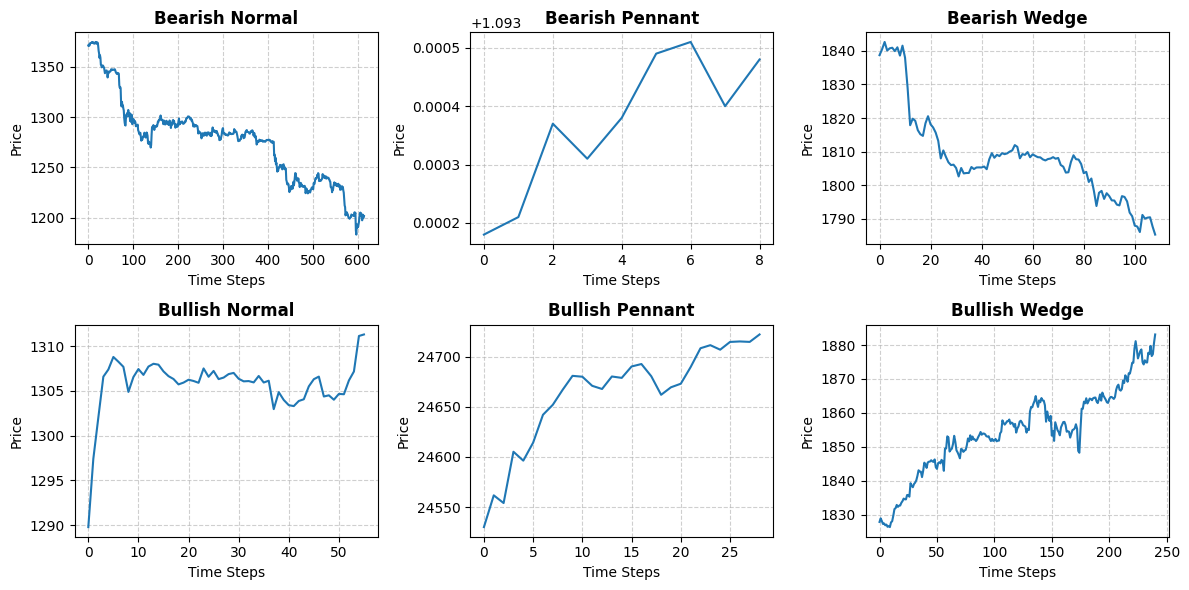

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, direction in enumerate(("Bearish", "Bullish")):
    for j, flag in enumerate(("Normal", "Pennant", "Wedge")):
        label = f"{direction} {flag}"
        if i >= len(axes):
            break

        example_seg_id = df_train[df_train["label"] == label]["segment_id"].iloc[1]

        segment_data = df_train[df_train["segment_id"] == example_seg_id].sort_values("_ts_ms")

        axes[i, j].plot(segment_data["close"].values, label="Close Price", color="tab:blue")

        axes[i, j].set_title(f"{label}", fontsize=12, fontweight="bold")
        axes[i, j].set_xlabel("Time Steps")
        axes[i, j].set_ylabel("Price")
        axes[i, j].grid(True, linestyle="--", alpha=0.6)


plt.tight_layout()